In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'
hist = hist[['open', 'high', 'low', 'close']]

In [6]:
hist

,open,high,low,close
time,,,,
2020-08-26,11330.56,11542.65,11259.23,11466.89
2020-08-27,11466.89,11591.64,11135.52,11331.02
2020-08-28,11331.02,11553.81,11289.07,11535.21
2020-08-29,11535.21,11585.98,11433.80,11480.48
2020-08-30,11480.48,11718.98,11470.07,11716.54
...,...,...,...,...
2022-01-04,46450.79,47529.48,45587.91,45824.54
2022-01-05,45824.54,47067.18,42510.86,43432.51
2022-01-06,43432.51,43779.23,42468.76,43094.54


In [7]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [8]:
split_row = len(hist) - int(0.2 * len(hist))
# split_row

train_data = hist.iloc[:split_row]
test_data = hist.iloc[split_row:]

# train_data
test_data

,open,high,low,close
time,,,,
2021-10-01,43829.34,48470.13,43304.82,48164.35
2021-10-02,48164.35,48347.69,47468.49,47669.02
2021-10-03,47669.02,49185.34,47137.07,48234.05
2021-10-04,48234.05,49501.21,46944.28,49276.91
2021-10-05,49276.91,51885.03,49087.72,51504.27
...,...,...,...,...
2022-01-04,46450.79,47529.48,45587.91,45824.54
2022-01-05,45824.54,47067.18,42510.86,43432.51
2022-01-06,43432.51,43779.23,42468.76,43094.54


In [9]:
train, test = train_test_split(hist, test_size=0.2)

In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

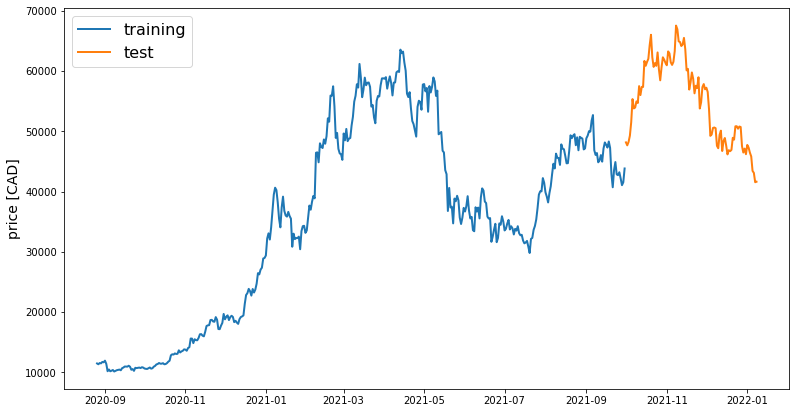

In [11]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [12]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [13]:
hist.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [14]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [15]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [16]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [18]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [19]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 3ms/step - loss: 0.0064
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 10/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 12/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 13/20
13/13 [==============================

In [20]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.027543694404230146

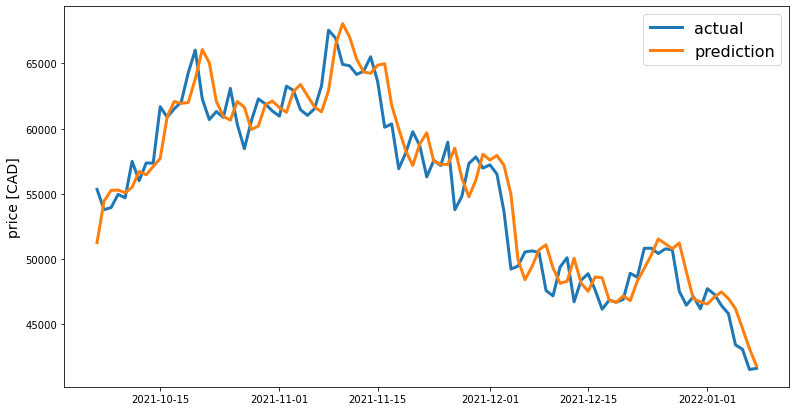

In [21]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)